In [354]:
%pip install tensorflow numpy matplotlib pandas scikit-learn seaborn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import Model, Input, layers, losses, activations, ops
from sklearn.model_selection import train_test_split
import pandas as pd
import json
import glob


2025-04-05 19:46:22.910398: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 19:46:22.911333: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 19:46:22.914672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 19:46:22.923623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743875182.939026 2017529 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743875182.94

In [53]:
def smooth(data, alpha=0.5):
    return pd.Series(data).ewm(alpha=alpha).mean().to_numpy()

In [54]:
def plot_hr(data):
    plt.figure(figsize=(18, 4))
    plt.plot(data)
    plt.ylim(0,200)
    plt.show()

In [295]:
def zero_constant_regions(data, window=10, threshold=0.01):
    data = np.asarray(data)
    result = np.copy(data)
    
    for i in range(len(data) - window + 1):
        segment = data[i:i+window]
        std = np.std(segment)
        
        if std < threshold:
            result[i:i+window] = 0  # Flatten to zero

    return result

In [474]:
raw = []

for json_file in glob.glob('rawhr/*.json'):
    with open(json_file, 'r') as file:
        data = json.load(file)
        hr = list(map(lambda x: x[1], data['heartRateValues']))

        if len(hr) != 720:
            print(json_file)
        
        raw.append(hr)

hr_data = []
target_hr_data = []

for i in range(10):
    
    d0 = list(map(lambda x: smooth(x, 1.0-(0.05*i)), raw))
    d1 = list(map(lambda x: smooth(x, 1.0-(0.05*(i+1))), raw))
    
    hr_data = hr_data + d0
    target_hr_data = target_hr_data + d1

hr_data = np.array(hr_data)
target_hr_data = np.array(target_hr_data)


hr_data = np.concatenate([hr_data, hr_data, hr_data, hr_data])
target_hr_data = np.concatenate([target_hr_data, target_hr_data, target_hr_data, target_hr_data])

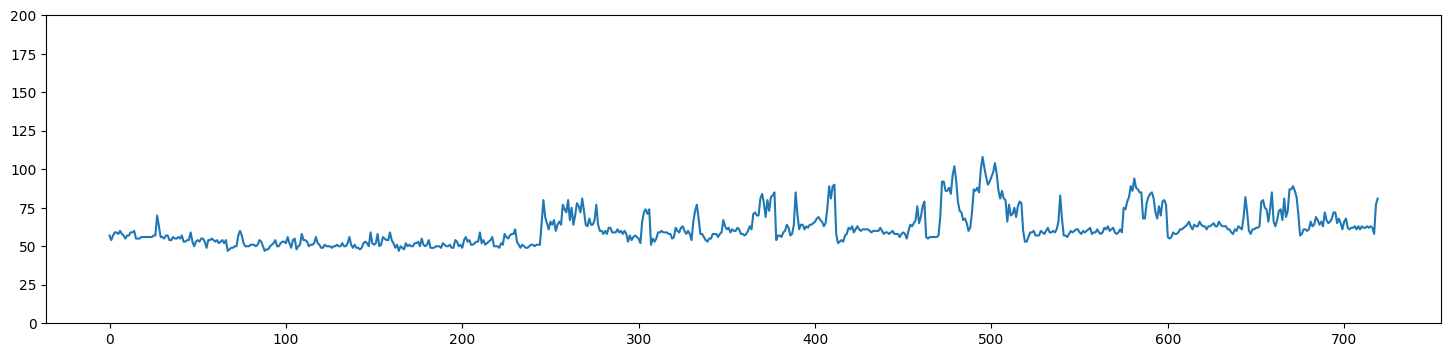

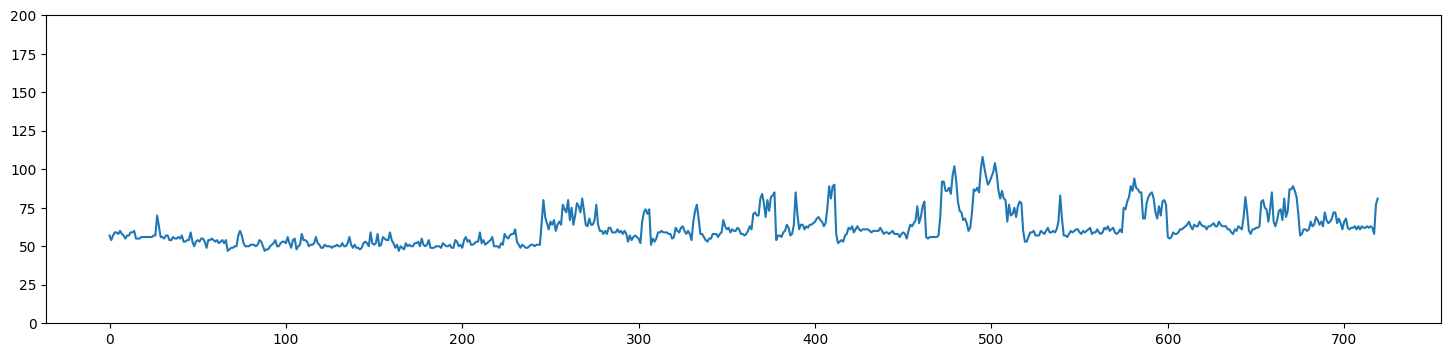

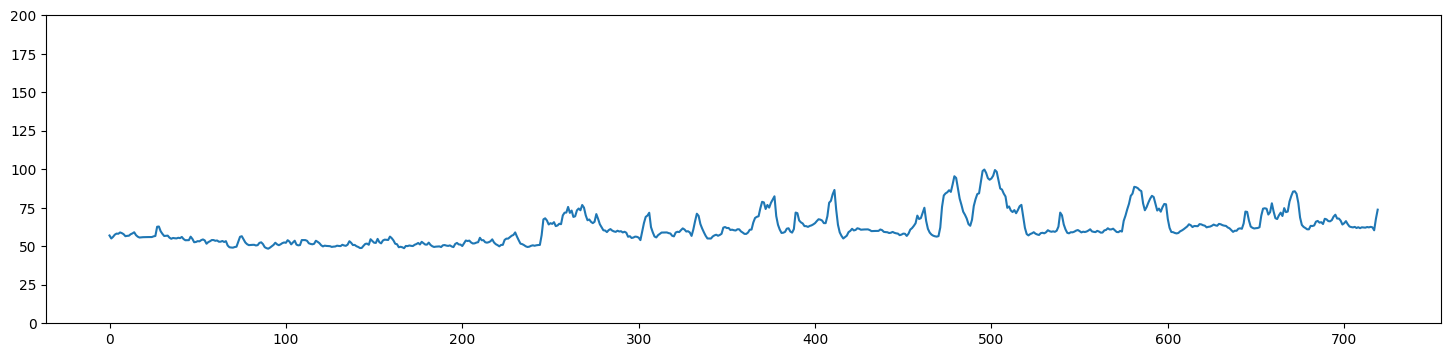

In [475]:
d_data = hr_data[6]
plot_hr(d_data)
plot_hr(smooth(d_data, 1))
plot_hr(smooth(d_data, 0.45))

In [476]:
x_train = hr_data.astype('float32') / 250.0
target_train = target_hr_data.astype('float32') / 250.0

x_train_normal, x_val_normal, target_train, target_val = train_test_split(x_train, target_train, test_size=0.25, random_state=42, shuffle=True)

print(x_train.shape, x_train_normal.shape, x_val_normal.shape, target_train.shape, target_val.shape)

(2800, 720) (2100, 720) (700, 720) (2100, 720) (700, 720)


In [477]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [478]:
Dense = layers.Dense

latent_dim = 4

def build_autoencoder(input_dim):
    input_encoder = Input(shape=(input_dim,))

    # Encoder
    x = Dense(720,"leaky_relu")(input_encoder)
    x = Dense(360,"leaky_relu" )(x)
    x = Dense(180,"leaky_relu")(x)
    x = Dense(90,"leaky_relu")(x)

    z_mu = Dense(latent_dim, name='latent_mu')(x)
    z_log_var = Dense(latent_dim, name='latent_logvar')(x)
    z = Sampling()([z_mu, z_log_var])

    encoder = Model(inputs=input_encoder, outputs=[z_mu, z_log_var, z], name='encoder')
    encoder.summary()

    #decoder
    input_decoder = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(90,"leaky_relu")(input_decoder)
    x = Dense(180,"leaky_relu")(x)
    x = Dense(360,"leaky_relu")(x)
    x = Dense(720,"leaky_relu")(x)
    dec = Dense(input_dim, activation='sigmoid')(x)    
    decoder = Model(inputs=input_decoder, outputs=dec, name='decoder_CNN')
    decoder.summary()
    
    vae_outputs = decoder(encoder(input_encoder)[2])
    vae = Model(input_encoder, vae_outputs, name='vae')
    vae.summary()
    return vae

In [479]:
# Build the autoencoder model
input_shape = 720
autoencoder = build_autoencoder(input_shape)

# Compile the model
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50      │ (None, 720)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_394 (Dense)   │ (None, 720)       │    519,120 │ input_layer_50[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_395 (Dense)   │ (None, 360)       │    259,560 │ dense_394[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_396 (Dense)   │ (None, 180)       │     64,980 │ dense_395[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_397 (Dense)   │ (None, 90)        │     16,290 │ dense_396[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 4)         │        364 │ dense_397[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_logvar       │ (None, 4)         │        364 │ dense_397[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_50         │ (None, 4)         │          0 │ latent_mu[0][0],  │
│ (Sampling)          │                   │            │ latent_logvar[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 860,678 (3.28 MB)

 Trainable params: 860,678 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 90)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_399 (Dense)               │ (None, 180)            │        16,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_400 (Dense)               │ (None, 360)            │        65,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 720)            │       259,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_402 (Dense)               │ (None, 720)            │       519,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 861,030 (3.28 MB)

 Trainable params: 861,030 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 4), (None, 4), │       860,678 │
│                                 │ (None, 4)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CNN (Functional)        │ (None, 720)            │       861,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,721,708 (6.57 MB)

 Trainable params: 1,721,708 (6.57 MB)

 Non-trainable params: 0 (0.00 B)

In [480]:
# Train the autoencoder on the training data
history = autoencoder.fit(x_train_normal, target_train,
                          epochs=20,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(x_val_normal, target_val))

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0161 - val_loss: 0.0030
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_lo

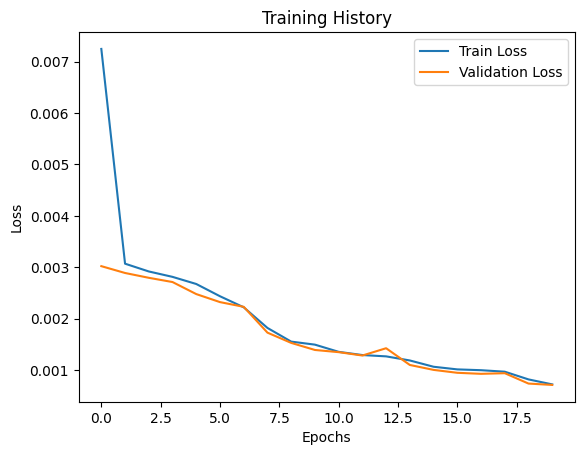

In [481]:
# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(10, 720)
(700, 720)
(700, 720)


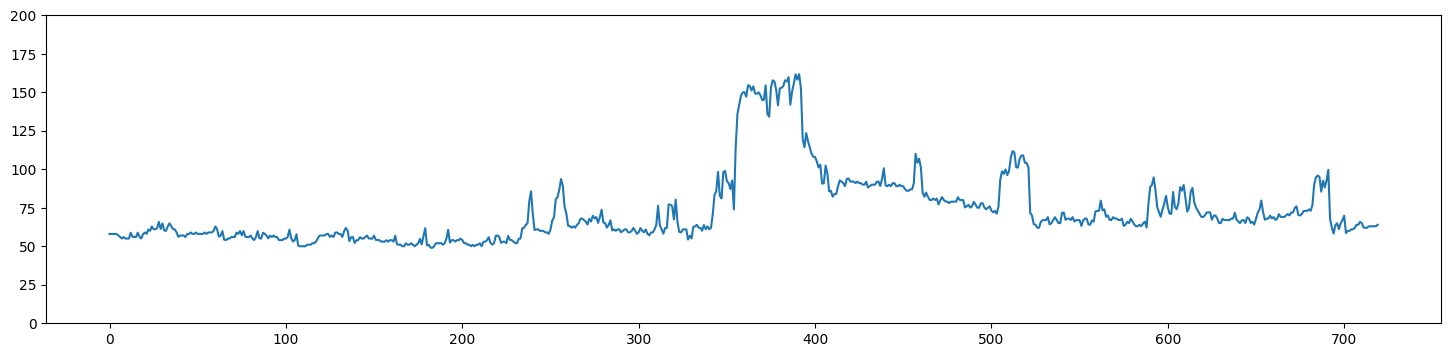

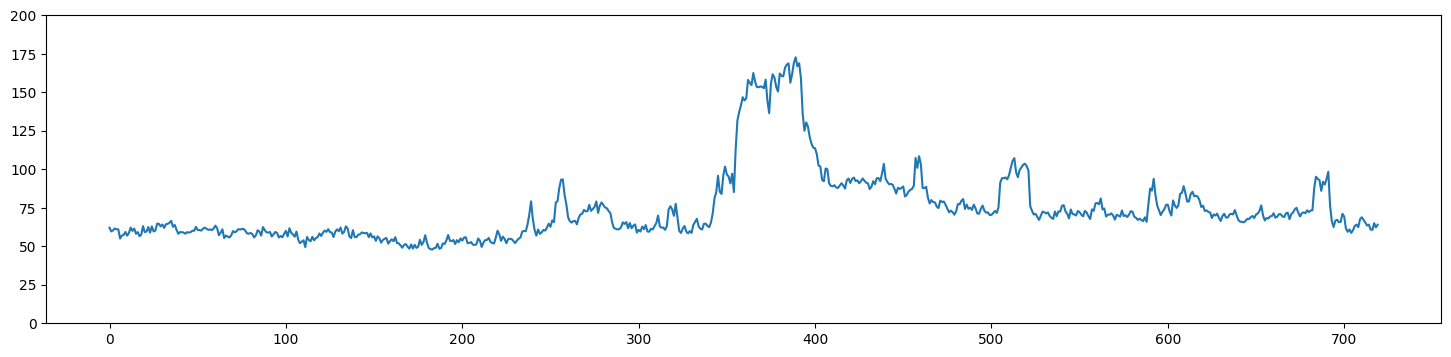

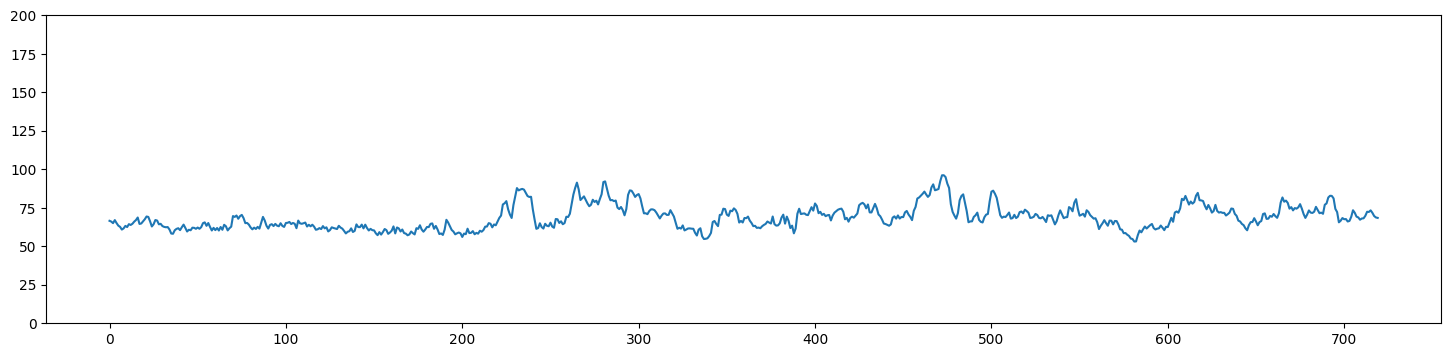

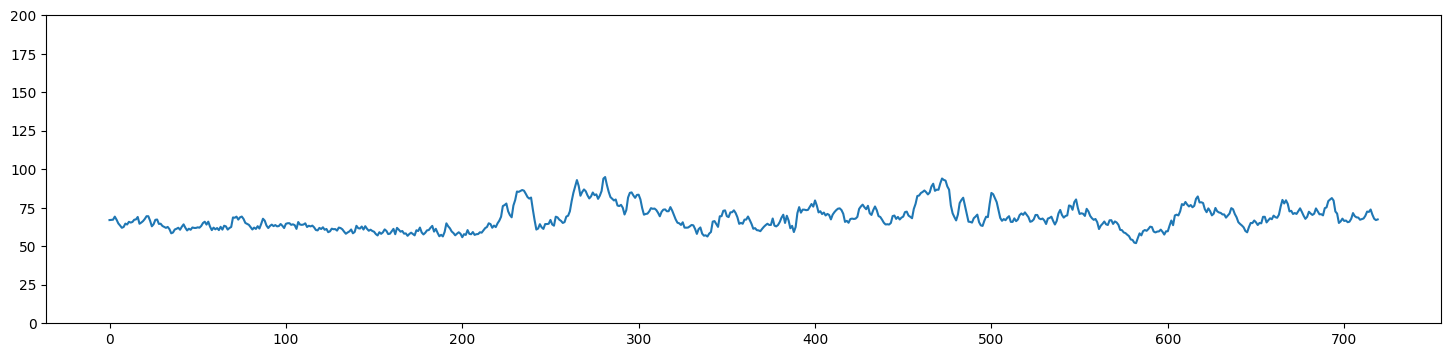

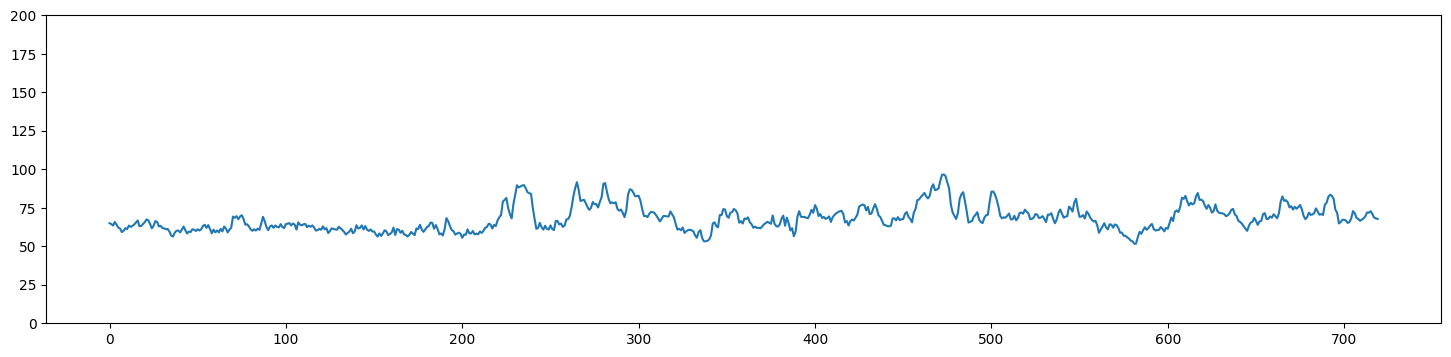

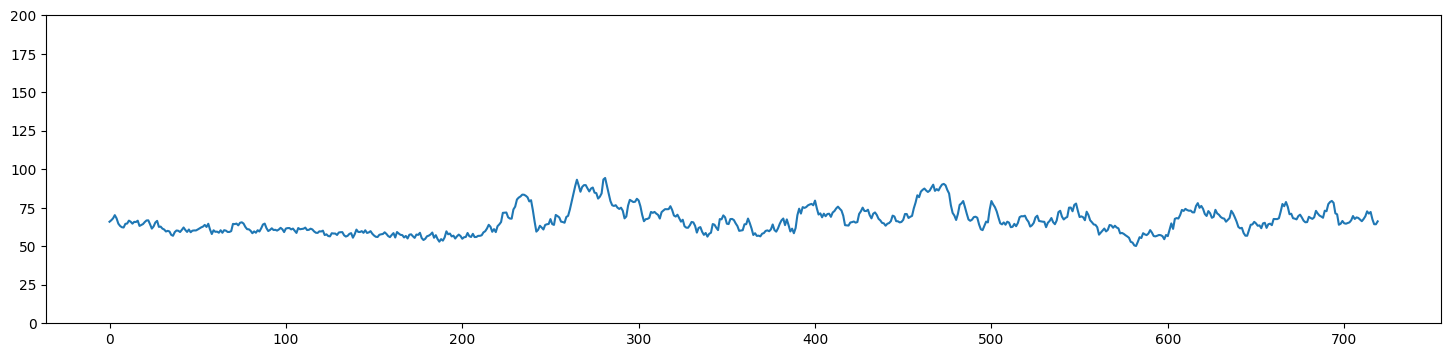

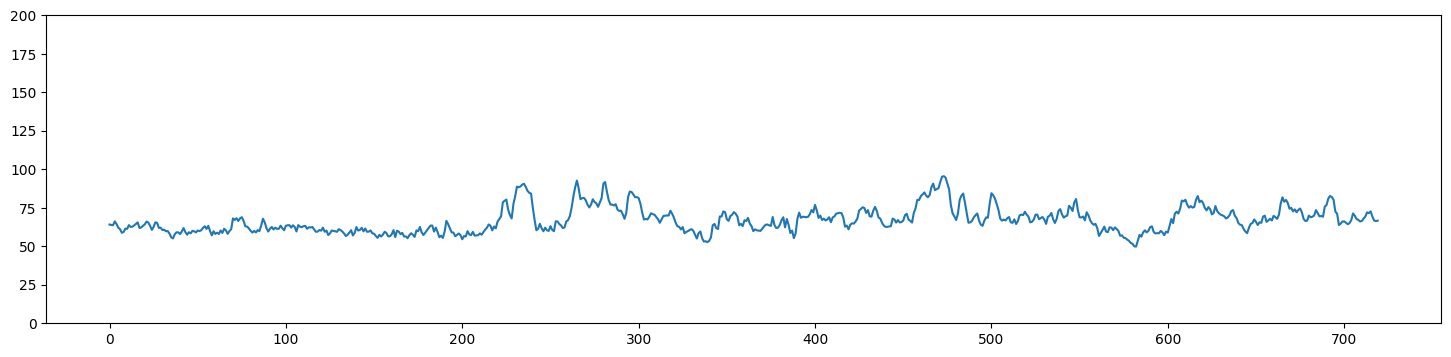

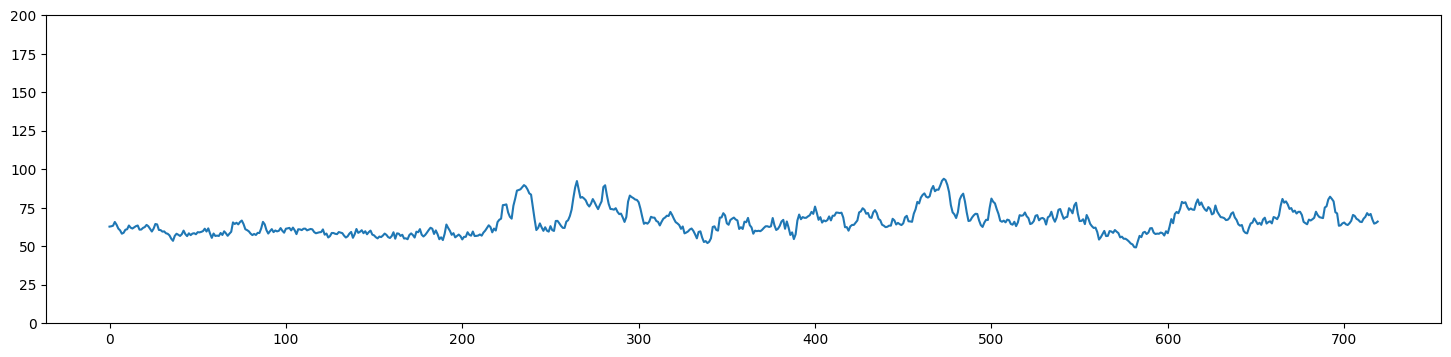

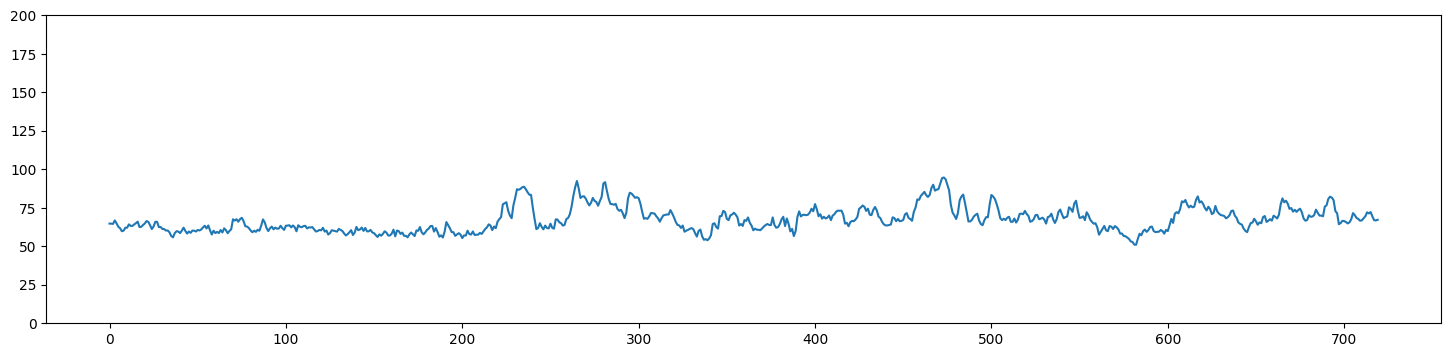

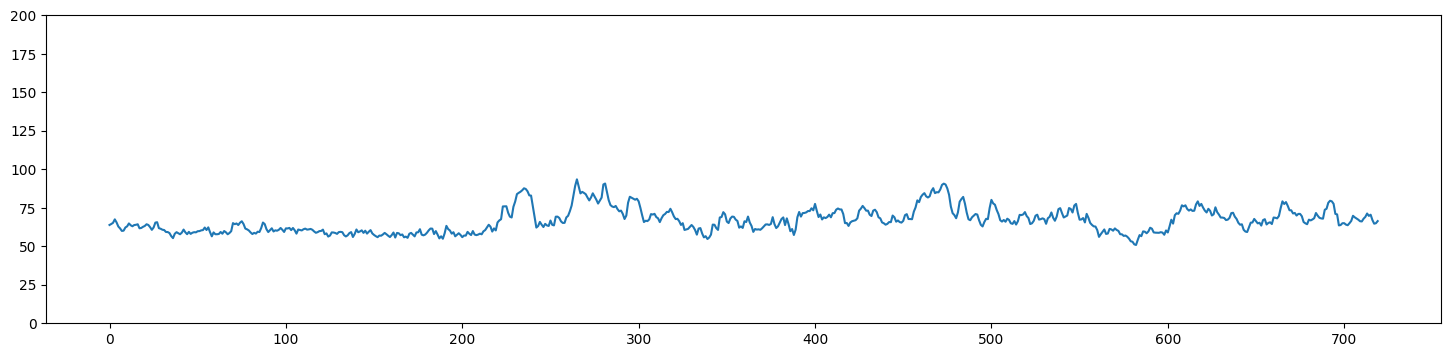

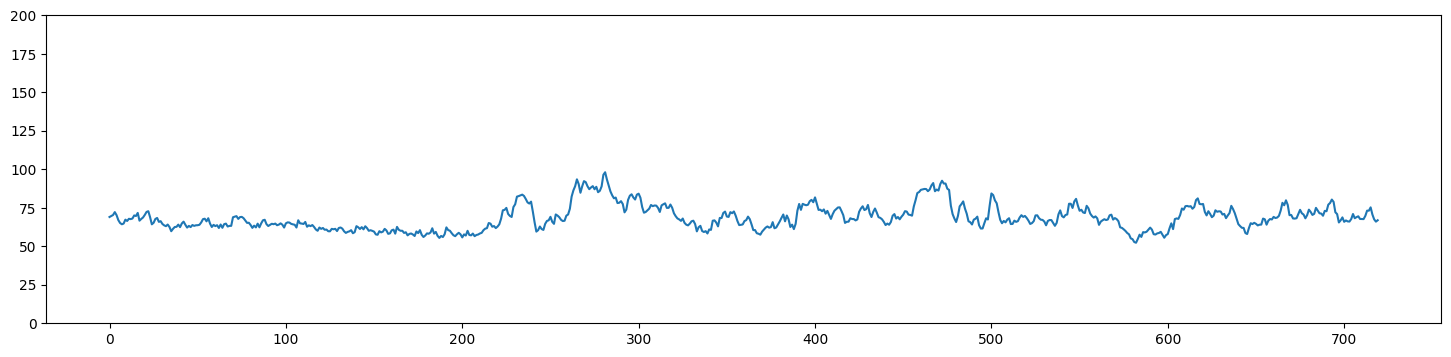

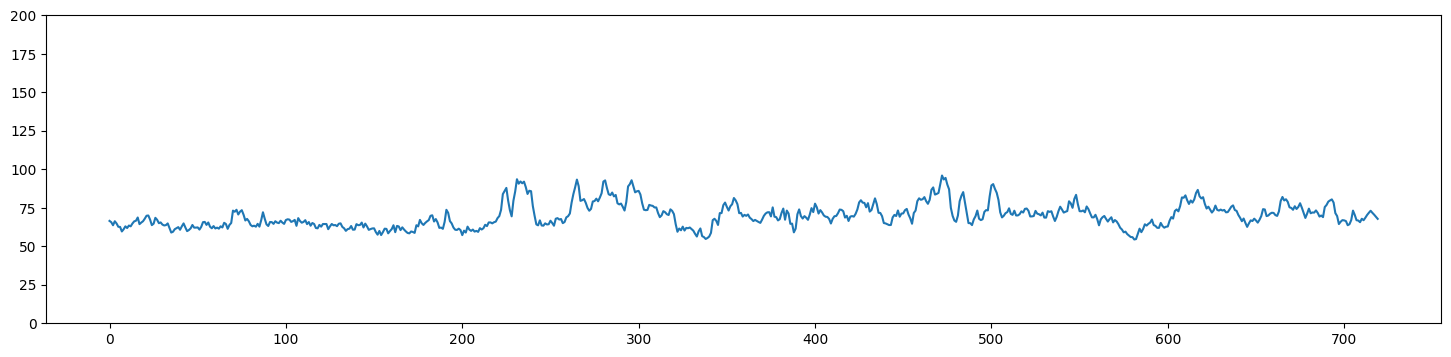

In [482]:
x_out_val = autoencoder.predict(x_val_normal)

newrandow = np.random.normal(loc=x_train_normal[10].mean(), scale=x_train_normal[10].std(),size=(10, 720))
newrandow = autoencoder.predict(newrandow)

print(newrandow.shape)
print(x_val_normal.shape)
print(x_out_val.shape)

plot_hr(x_val_normal[1]*250)
plot_hr(x_out_val[1]*250)

for i in range(10):
    plot_hr(newrandow[i]*250)